#### Required Libraries

In [107]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import scipy as sco
from scipy.stats import norm
from scipy import stats
import matplotlib.lines as mlines
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

#### Data Collecting

In [108]:
# Traditional Asset Classes Study. 1- Local (EM) Equities, 2- Developed Market Equities, 3- Real Estate, 4- Cash (country rates)
# IBOV, IVV (S&P500 + USD/BRL), IFIX, CDI, respectively.

# Defining dates range
start_date = '2013-01-01'
end_date = '2023-10-20'
start_date_br = datetime.strptime(start_date, '%Y-%m-%d').strftime('%d/%m/%Y')
end_date_br = datetime.strptime(end_date, '%Y-%m-%d').strftime('%d/%m/%Y')

# Symbols on YahooFinance
dollar_symbol = 'BRL=X'
sp500_symbol = 'IVV'
ibov_symbol = '^BVSP'

# Simple Returns will be used, mainly because of Asset combinations on portfolio. Solely evaluated, Log-Returns would do better.

# IBOV Data - Yahoo Finance
ibov_data = yf.download(ibov_symbol, start=start_date, end=end_date)

# IFIX Data - Reading local spreadsheet file. Collected w/ Google Sheets & Google Finance. YF doesn't have the data.
ifix_data = pd.read_excel('Historico IFIX 01-01-2013 ate 20-10-2023.xlsx', index_col='Date')
# Filtering. IFIX Start Date: set/2012)
ifix_data = ifix_data[(ifix_data.index >= start_date) & (ifix_data.index <= end_date)]
ifix_data.index = ifix_data.index.normalize()

# IVV Data - S&P500 index variation + USD/BRL exchange.
dollar_data = yf.download(dollar_symbol, start=start_date, end=end_date)
sp500_data = yf.download(sp500_symbol, start=start_date, end=end_date)
# Joining to combine variations
ivv_data = pd.concat([dollar_data['Close'], sp500_data['Close']], axis=1)
ivv_data.columns = ['Dollar', 'SP500']

# CDI Data - Central Bank API. Fetch and returns an interval with daily Selic rates data
url_bcb = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={start_date_br}&dataFinal={end_date_br}'
# url_bcb = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=json&dataInicial={start_date_br}&dataFinal={end_date_br}'
cdi_data = pd.read_json(url_bcb)
cdi_data['data'] = pd.to_datetime(cdi_data['data'], format='%d/%m/%Y')
cdi_data = cdi_data.set_index('data')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Data Processing: Cleaning & Standardization

In [109]:
print(f"""
Yearly Avg Return and Std Dev for all Indices.\n
*OBS: Method: calculating daily pct change for each Index dataframe separately. Mean*252\n
From {start_date} to {end_date}\n\n
""")

# IBOV Data
ibov_data_daily_pctg = pd.DataFrame(ibov_data['Adj Close'].pct_change().fillna(0)*100)
ibov_avg_return = ibov_data_daily_pctg.mean()*252
ibov_avg_return = ibov_avg_return.rename({'Adj Close': 'IBOV Avg Return'})
ibov_std_dev = ibov_data_daily_pctg.ewm(span=252).std().iloc[-1] * np.sqrt(252)
ibov_std_dev = ibov_std_dev.rename({'Adj Close': 'IBOV Std Dev'})
ibov_stat_data = pd.DataFrame(pd.concat([ibov_avg_return, ibov_std_dev])).transpose()
ibov_data_daily_pctg = ibov_data_daily_pctg.rename(columns={'Adj Close': 'IBOV'})
print(ibov_stat_data.to_string(index=False), "\n")

# IFIX Data
ifix_data_daily_pctg = pd.DataFrame(ifix_data['Close'].pct_change().fillna(0)*100)
ifix_avg_return = ifix_data_daily_pctg.mean()*252
ifix_avg_return = ifix_avg_return.rename({'Close': 'IFIX Avg Return'})
ifix_std_dev = ifix_data_daily_pctg.ewm(span=252).std().iloc[-1] * np.sqrt(252)
ifix_std_dev = ifix_std_dev.rename({'Close': 'IFIX Std Dev'})
ifix_stat_data = pd.DataFrame(pd.concat([ifix_avg_return, ifix_std_dev])).transpose()
ifix_data_daily_pctg = ifix_data_daily_pctg.rename(columns={'Close': 'IFIX'})
print(ifix_stat_data.to_string(index=False), "\n")

# IVV Data
ivv_data_daily_pctg = pd.DataFrame(ivv_data.pct_change().fillna(0)*100)
ivv_data_daily_pctg['IVV'] =  ivv_data_daily_pctg['Dollar'] + ivv_data_daily_pctg['SP500'] # Adding up variations
ivv_data_daily_pctg.drop(ivv_data_daily_pctg[['Dollar', 'SP500']], axis=1)
ivv_avg_return = ivv_data_daily_pctg.mean()*252
ivv_avg_return = ivv_avg_return.rename({'Dollar': 'Dollar Avg Return', 'SP500': 'SP500 Avg Return', 'IVV': 'IVV Avg Return'})
ivv_std_dev = ivv_data_daily_pctg.ewm(span=252).std().iloc[-1] * np.sqrt(252)
ivv_std_dev = ivv_std_dev.rename({'Dollar': 'Dollar Std Dev', 'SP500': 'SP500 Std Dev', 'IVV': 'IVV Std Dev'})
ivv_stat_data = pd.DataFrame(pd.concat([ivv_avg_return, ivv_std_dev])).transpose()
print(ivv_stat_data[['IVV Avg Return', 'IVV Std Dev']].to_string(index=False), "\n")
# print(ivv_stat_data.to_string(index=False), "\n")

# CDI Data
cdi_data_daily_pctg = cdi_data
cdi_avg_return = cdi_data_daily_pctg.mean()*252
cdi_avg_return = cdi_avg_return.rename({'valor': 'CDI Avg Return'})
cdi_std_dev = cdi_data_daily_pctg.std()*252
cdi_std_dev = cdi_std_dev.rename({'valor': 'CDI Std Dev'})
cdi_stat_data = pd.DataFrame(pd.concat([cdi_avg_return, cdi_std_dev])).transpose()
cdi_data_daily_pctg = cdi_data_daily_pctg.rename(columns={'valor': 'CDI'})
print(cdi_stat_data.to_string(index=False), "\n")

# Consolidated daily variation for all indices
consolidated_variation = pd.concat([ibov_data_daily_pctg,
                                    pd.DataFrame(ivv_data_daily_pctg['IVV']).shift(-1), 
                                    ifix_data_daily_pctg,
                                    cdi_data_daily_pctg],
                                    axis=1).fillna(0)


Yearly Avg Return and Std Dev for all Indices.

*OBS: Method: calculating daily pct change for each Index dataframe separately. Mean*252

From 2013-01-01 to 2023-10-20



 IBOV Avg Return  IBOV Std Dev
         8.72636     18.079011 

 IFIX Avg Return  IFIX Std Dev
        6.912262      4.891274 

 IVV Avg Return  IVV Std Dev
      20.560215    19.110095 

 CDI Avg Return  CDI Std Dev
       8.745783     3.623332 



#### Correlation Matrix

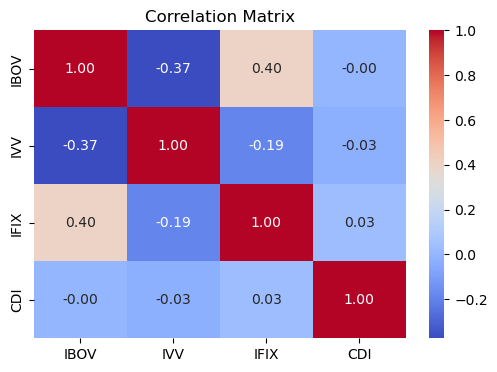

In [110]:
correlation_matrix = consolidated_variation.corr()

# Seaborn map
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')  
plt.show()

# Covariance Matrix - 252 for Annualized
consolidated_variation_cov = consolidated_variation.cov()*252

#### Random Portfolios Generation

In [111]:
# Portfolios Qty
n_portfolios = 6000

# List of returns, volatility and weight of asset classes in portfolio
p_ret=[]
p_vol=[]
p_weights=[] # Percentage for each Asset Class (Index)

# Excluding Risk-Free Rate (CDI) for portfolio optimization
consolidated_variation_without_cdi = consolidated_variation[['IBOV', 'IVV', 'IFIX']]
consolidated_variation_cov_without_cdi = consolidated_variation_cov.loc[['IBOV', 'IVV', 'IFIX'], 
                                                                        ['IBOV', 'IVV', 'IFIX']]

# Asset Classes Qty
n_asset_classes=len(consolidated_variation_without_cdi.columns) 

for portfolios in range(n_portfolios):
    weights=np.random.random(n_asset_classes) # Random weights
    weights=weights/np.sum(weights) # Weights sum must be = 1 (100% allocated)
    p_weights.append(weights)
    
    returns=np.dot(weights, consolidated_variation_without_cdi.mean()*252) # Returns

    p_ret.append(returns)
    
    # var=consolidated_variation_cov_without_cdi.mul(weights, axis=0).mul(weights, axis=1).sum().sum() # Covariância
    var = np.dot(weights, np.dot(consolidated_variation_cov_without_cdi.values, weights))  # Variance

    dp=np.sqrt(var) # Desvio-Padrão
    p_vol.append(dp)

p_ret=np.array(p_ret)
p_vol=np.array(p_vol)
dados={'Return': p_ret, 'Std Dev': p_vol}
portfolios=pd.DataFrame(dados)
portfolios

,Return,Std Dev
0,7.711584,15.838109
1,7.742837,7.442772
2,9.730317,8.836456
3,12.100597,9.501169
4,10.189331,9.319877
...,...,...
5995,15.176682,13.306069
5996,10.899480,11.456395
5997,11.147981,9.986300
5998,12.303735,9.534283


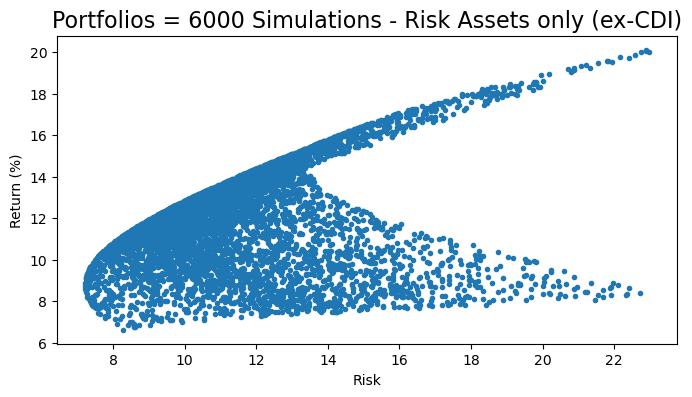

In [134]:
# Portfolios Chart - OBS: Only Risk Assets. CDI was not considered.
plt.figure(figsize=(8,4))
plt.scatter(portfolios['Std Dev'], portfolios['Return'], marker='.')
plt.title(f'Portfolios = {n_portfolios} Simulations - Risk Assets only (ex-CDI)', fontsize=16)
plt.xlabel('Risk')
plt.ylabel('Return (%)')

plt.show()

#### Portfolios Optimization

In [113]:
# Function definition for Return and Risk calculation

def port_ret(weights): # Return calculation function
    return np.sum(consolidated_variation_without_cdi.mean()*252*weights)

def port_vol(weights): # Risk calculation function
    return math.sqrt(np.dot(weights, np.dot(consolidated_variation_cov_without_cdi, weights)))
    # Remember that np.dot ignores .T of vector transposition. Always do the automatic multiplication

#### Function Constraints

In [114]:
# Function constraints definition

min_lim = 0.00 # Minimum limit of allocation (for each asset)
max_lim = 1-min_lim # Maximum limit of allocation (for each asset)

constr = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}) # Weights sum equals 1
bnds = tuple((min_lim, max_lim) for x in range(n_asset_classes)) # Generates a tuple (min_lim, max_lim) for each Asset Class
weights_i = np.array(n_asset_classes*[1/n_asset_classes]) # Initiates with same weight for all Assets

#### Optimized Minimum Risk Portfolio

Labels:  ['IBOV', 'IVV', 'IFIX'] 
 Less risky Portfolio weights:  [0.04 0.16 0.81] 
 Less risky Portfolio returns:  8.80% 
 Less risky Portfolio volatility:  7.21%


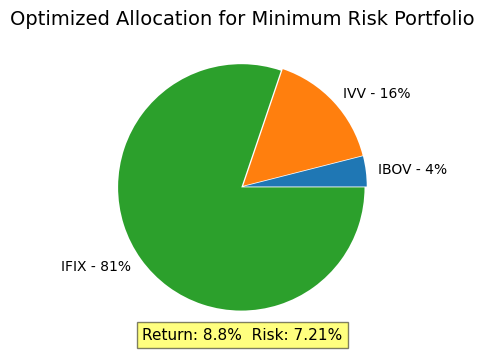

In [115]:
# Portfolio Optimization - Less Risky portfolio
optimal_less_vol=sco.optimize.minimize(port_vol, weights_i, method='SLSQP', bounds=bnds, constraints=constr)

# Optimized weights with less risk (volatility)
optimal_weight = optimal_less_vol['x'].round(2)
optimal_ret = port_ret(optimal_less_vol['x'])
optimal_vol = port_vol(optimal_less_vol['x'])

columns_label = consolidated_variation_cov_without_cdi.columns.to_list()
print('Labels: ', columns_label, '\n',
     'Less risky Portfolio weights: ', optimal_weight, '\n',
     'Less risky Portfolio returns: ', '{:.2%}'.format(optimal_ret/100), '\n',
     'Less risky Portfolio volatility: ', '{:.2%}'.format(optimal_vol/100))

# Portfolio Info
portfolio_info = (f"Return: {round(optimal_ret, 2)}%  Risk: {round(optimal_vol, 2)}%")

# Little spacing between the 3 slices
explode = (0.01, 0.01, 0.01)

combined_list = [f'{label} - {weight*100:.0f}%' for label, weight in zip(columns_label, optimal_weight)]
# Generating Pie Chart for suggested allocation
plt.figure(figsize=(8,4))
plt.pie(optimal_weight, labels=combined_list, explode=explode)
plt.title('Optimized Allocation for Minimum Risk Portfolio', fontsize=14)
plt.text(0, -1.2, portfolio_info, ha='center', va='center', fontsize=11,
         bbox=dict(facecolor='yellow', alpha=0.5))
plt.show()

In [116]:
# Efficient Frontier line estimation
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret}, {'type':'eq', 'fun': lambda x: np.sum(x)-1})
trets = np.linspace(p_ret.min(), p_ret.max(), 50)
tvols=[]

for tret in trets:
    res = sco.optimize.minimize(port_vol, weights_i, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
    
tvols=np.array(tvols)

#### Risk-Free rate

In [117]:
risk_free_tx = float("{:.2f}".format(float(str(cdi_avg_return.values.tolist()).strip('[]'))))
print("Risk Free Rate:\n", risk_free_tx)

Risk Free Rate:
 8.75


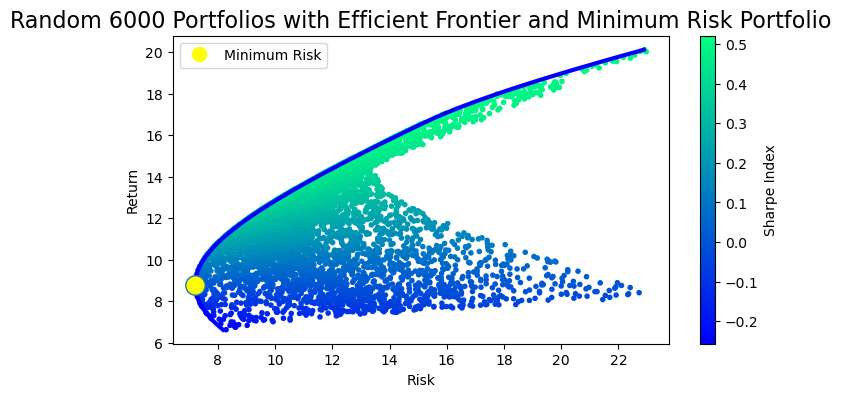

In [118]:
# Efficient Frontier chart with Minimum Risk portfolio
plt.figure(figsize=(8,4))
plt.scatter(p_vol, p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='winter')
plt.plot(tvols, trets, 'b', lw=3)
plt.plot(port_vol(optimal_less_vol['x']), port_ret(optimal_less_vol['x']), 'o', markerfacecolor='yellow', markersize=14)
plt.title(f'Random {n_portfolios} Portfolios with Efficient Frontier and Minimum Risk Portfolio', fontsize=16)
plt.xlabel('Risk')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Index')

# Using mlines objects because matplotlib markers do not generate Legend
yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Minimum Risk')
plt.legend(handles=[yellow_circle])
plt.show()

#### Maximum Sharpe portfolio

In [119]:
# Maximum Sharpe portfolio
def max_sharpe_func(weights):
    return -(port_ret(weights)-risk_free_tx)/port_vol(weights)

# Sharpe Optimization
optimal_sharpe = sco.optimize.minimize(max_sharpe_func, weights_i, method='SLSQP', bounds=bnds, constraints=constr)

Labels:  ['IBOV', 'IVV', 'IFIX'] 
 Maximum Sharpe portfolio weights:  [0.25 0.75 0.  ] 
 Maximum Sharpe portfolio returns:  17.45% 
 Maximum Sharpe portfolio risk:  16.66%


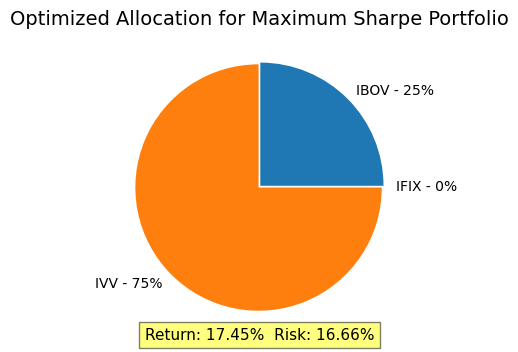

In [120]:
optimal_weight = optimal_sharpe['x'].round(2)
optimal_ret = port_ret(optimal_sharpe['x'])
optimal_vol = port_vol(optimal_sharpe['x'])

print('Labels: ',columns_label, '\n',
     'Maximum Sharpe portfolio weights: ', optimal_weight, '\n',
     'Maximum Sharpe portfolio returns: ', '{:.2%}'.format(optimal_ret/100), '\n',
     'Maximum Sharpe portfolio risk: ', '{:.2%}'.format(optimal_vol/100))

# Portfolio Info
portfolio_info = (f"Return: {round(optimal_ret, 2)}%  Risk: {round(optimal_vol, 2)}%")

# Little spacing between the 3 slices
explode = (0.01, 0.01, 0.01)

combined_list = [f'{label} - {weight*100:.0f}%' for label, weight in zip(columns_label, optimal_weight)]
# Generating Pie Chart for suggested allocation
plt.figure(figsize=(8,4))
plt.pie(optimal_weight, labels=combined_list, explode=explode)
plt.title('Optimized Allocation for Maximum Sharpe Portfolio', fontsize=14)
plt.text(0, -1.2, portfolio_info, ha='center', va='center', fontsize=11,
         bbox=dict(facecolor='yellow', alpha=0.5))
plt.show()

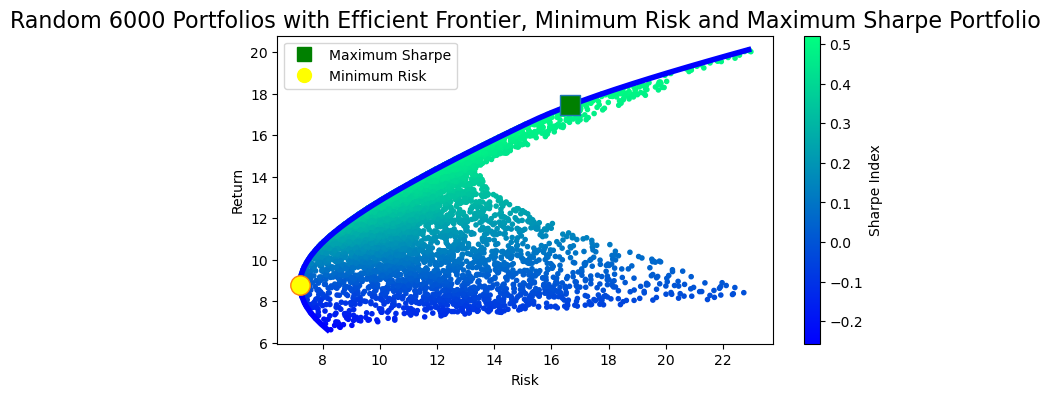

In [121]:
# Efficient Frontier chart with Minimum Risk and Maximum Sharpe portfolio
plt.figure(figsize=(8,4))
plt.scatter(p_vol, p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='winter')
plt.plot(tvols, trets, 'b', lw=4)
plt.plot(port_vol(optimal_sharpe['x']), port_ret(optimal_sharpe['x']), 's', markerfacecolor='green', markersize=14) # Max Sharpe
plt.plot(port_vol(optimal_less_vol['x']), port_ret(optimal_less_vol['x']), 'o' , markerfacecolor='yellow', markersize=14) # Min Risk
plt.title(f'Random {n_portfolios} Portfolios with Efficient Frontier, Minimum Risk and Maximum Sharpe Portfolio', fontsize=16)
plt.xlabel('Risk')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Index')

# Using mlines objects because matplotlib markers do not generate Legend
green_square = mlines.Line2D([], [], color='green', marker='s', linestyle='None',
                          markersize=10, label='Maximum Sharpe')

yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Minimum Risk')

plt.legend(handles=[green_square, yellow_circle])
plt.show()

#### Capital Allocation Line - Risk-Free and Risky Assets Combination

##### Parameters: Risk-Aversion

In [122]:
# Capital Allocation Line - CAL
# The smaller the parameter, the greater the risk aversion
# er = expected return, u = utility, sd = std dev 

a = 8 # Aversion level

# Markowitz utility maximization model
eixo_x=[]
eixo_y=[]
utility=[]

for er in np.linspace(risk_free_tx, max(trets),20):
    sd=(er-risk_free_tx)/((port_ret(optimal_sharpe['x'])-risk_free_tx)/port_vol(optimal_sharpe['x']))
    u = er -0.5*a*(sd**2)
    eixo_x.append(sd)
    eixo_y.append(er)
    utility.append(u)
    
data3={'Utility':utility, 'Return':eixo_y, 'Risk': eixo_x}
cal=pd.DataFrame(data3)

In [123]:
# Estimating complete Optimized Portfolio
wp = (port_ret(optimal_sharpe['x'])-risk_free_tx)/(a*port_vol(optimal_sharpe['x'])**2)
r_oc = wp*port_ret(optimal_sharpe['x'])+(1-wp)*risk_free_tx
v_oc = wp*port_vol(optimal_sharpe['x'])
wp

0.003917417886763317

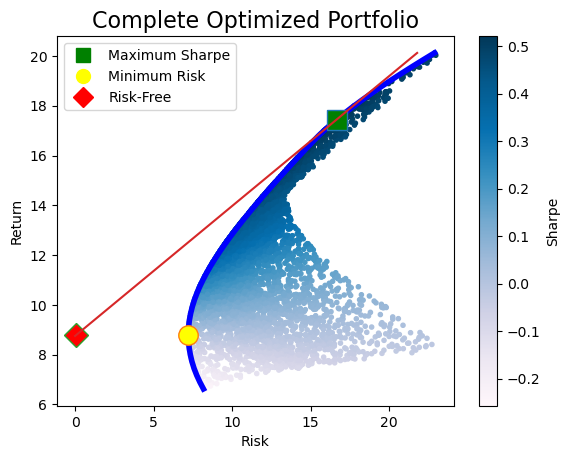

In [124]:
# Complete Optimized Portfolio chart
plt.scatter(p_vol,p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='PuBu')
plt.plot(tvols,trets,'b',lw=4)
plt.plot(port_vol(optimal_sharpe['x']), port_ret(optimal_sharpe['x']), 's', markerfacecolor='green', markersize=14) # Max Sharpe
plt.plot(port_vol(optimal_less_vol['x']), port_ret(optimal_less_vol['x']), 'o' , markerfacecolor='yellow', markersize=14) # Min Risk
plt.plot(v_oc, r_oc, 'D', markerfacecolor='red', markersize=12) # Risk-Free
plt.plot(eixo_x, eixo_y)
plt.title('Complete Optimized Portfolio', fontsize=16)
plt.xlabel('Risk')
plt.ylabel('Return')
plt.colorbar(label='Sharpe')

# Using mlines objects because matplotlib markers do not generate Legend
green_square = mlines.Line2D([], [], color='green', marker='s', linestyle='None',
                          markersize=10, label='Maximum Sharpe')

yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Minimum Risk')
red_diamond = mlines.Line2D([], [], color='red', marker='D', linestyle='None',
                          markersize=10, label='Risk-Free')

plt.legend(handles=[green_square, yellow_circle, red_diamond])
plt.show()

#### Portfolio Simulation

In [125]:
# Set the weights for: IBOV, IVV, IFIX, CDI respectively

port_weights = np.array([0.35, 0.15, 0.25, 0.25 ])
port_weights

# Creating Return and Risk calculation functions
def simulated_port_ret(weights): # Return
    return np.sum(consolidated_variation.mean()*252*weights)

def simulated_port_vol(weights): # Risk
    return math.sqrt(np.dot(weights, np.dot(consolidated_variation_cov, weights)))

expected_return = round(simulated_port_ret(port_weights), 2)
expected_risk = round(simulated_port_vol(port_weights), 2)

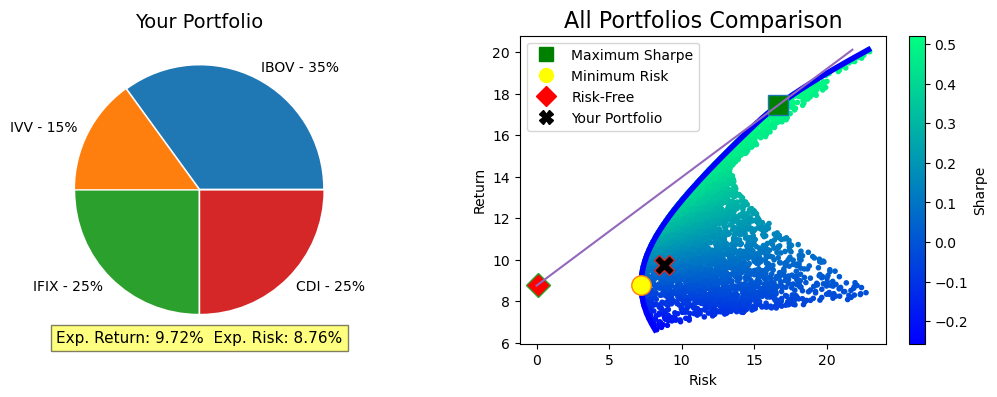

In [126]:
# Your Portfolio:
portfolio_info = (f"Exp. Return: {expected_return}%  Exp. Risk: {expected_risk}%")

# Support Variables
assets_list = consolidated_variation.columns.to_list()
portfolio_list = [f'{label} - {weight*100:.0f}%' for label, weight in zip(assets_list, port_weights)]
return_n_risk_tpl = (expected_return, expected_risk) # Return and Risk, respectively

# Little spacing between the 4 slices
explode = (0.01, 0.01, 0.01, 0.01)

# -------- Plotting Your Portfolio on Efficient Curve simulations --------

# Creating charts - Grid
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
port_pie_chart = axs[0]
port_on_efficient_curve = axs[1]

# Chart 1 - Pie Chart
port_pie_chart.pie(port_weights, labels=portfolio_list, explode=explode)
port_pie_chart.set_title('Your Portfolio', fontsize=14)
port_pie_chart.text(0, -1.2, portfolio_info, ha='center', va='center', fontsize=11,
         bbox=dict(facecolor='yellow', alpha=0.5))

# Chart 2 - Positioning your portfolio on Efficient Curve simulations
scatter = port_on_efficient_curve.scatter(p_vol,p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='winter')
port_on_efficient_curve.plot(tvols,trets,'b',lw=4)
port_on_efficient_curve.plot(port_vol(optimal_sharpe['x']), port_ret(optimal_sharpe['x']), 's', markerfacecolor='green', markersize=14) # Max Sharpe
port_on_efficient_curve.plot(port_vol(optimal_less_vol['x']), port_ret(optimal_less_vol['x']), 'o' , markerfacecolor='yellow', markersize=14) # Min Risk
port_on_efficient_curve.plot(v_oc, r_oc, 'D', markerfacecolor='red', markersize=12) # Risk-Free
port_on_efficient_curve.plot(return_n_risk_tpl[1], return_n_risk_tpl[0], 'X', markerfacecolor='black', markersize=15) # Your Portfolio

port_on_efficient_curve.plot(eixo_x, eixo_y)
port_on_efficient_curve.set_title('All Portfolios Comparison', fontsize=16)
plt.xlabel('Risk')
plt.ylabel('Return')
# Creating colorbar associated with the second chart
cbar = plt.colorbar(scatter, ax=port_on_efficient_curve, label='Sharpe')

# Using mlines objects because matplotlib markers do not generate Legend
green_square = mlines.Line2D([], [], color='green', marker='s', linestyle='None',
                          markersize=10, label='Maximum Sharpe')

yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Minimum Risk')
red_diamond = mlines.Line2D([], [], color='red', marker='D', linestyle='None',
                          markersize=10, label='Risk-Free')
black_x = mlines.Line2D([], [], color='black', marker='X', linestyle='None',
                          markersize=10, label='Your Portfolio')

port_on_efficient_curve.legend(handles=[green_square, yellow_circle, red_diamond, black_x])
plt.show()

#### Portfolios Return Distribution (Normal Curve)

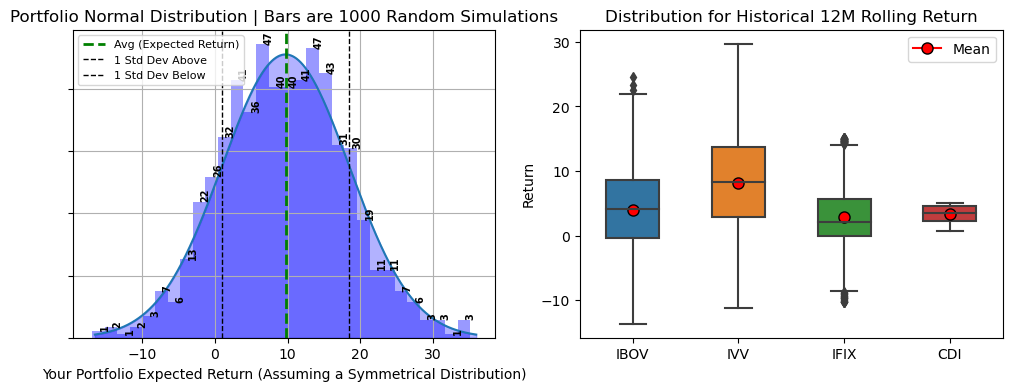

In [127]:
# Defining constants with Risk/Return characteristics of portfolio
mu = return_n_risk_tpl[0]  # Avg (Expected Return)
sigma = return_n_risk_tpl[1]  # Std Dev (Expected Risk)

# Calculating superior and inferior results. 3 Std Devs as premise
lower_bound = mu - 3 * sigma
upper_bound = mu + 3 * sigma

# Calculating z-score
z1 = (lower_bound - mu) / sigma
z2 = (upper_bound - mu) / sigma

# Calculating probability with pdf function from SciPy
x = np.arange(lower_bound, upper_bound, 0.001)
y = norm.pdf(x, mu, sigma)

# Random Data on Normal Distribution
# np.random.seed(X) # X as a random integer number in order to "pin" a random state
qty_random_simulations = 1000
return_random_normal_distribution = np.random.normal(return_n_risk_tpl[0], return_n_risk_tpl[1], qty_random_simulations)

# Creating charts - Grid
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
chart1 = axs[0]
chart2 = axs[1]

# 1 - Bell Curve for Your Portfolio Normal Distribution
chart1.plot(x, y)
counts, edges, _ = chart1.hist(return_random_normal_distribution, bins=30, density=True, alpha=0.4, color='blue')
rounded_counts = [round(round(number*1000, 2)) for number in counts]

# Fills in the area under the bell curve
chart1.fill_between(x, y, 0, alpha=0.3, color='b')

# Adding lines for mean and standard deviations
chart1.axvline(mu, color='green', linestyle='dashed', linewidth=2, label='Avg (Expected Return)')
chart1.axvline(mu - sigma, color='black', linestyle='dashed', linewidth=1, label='1 Std Dev Above')
chart1.axvline(mu + sigma, color='black', linestyle='dashed', linewidth=1, label='1 Std Dev Below')

chart1.set_xlabel('Your Portfolio Expected Return (Assuming a Symmetrical Distribution)')
chart1.set_yticklabels([])
chart1.set_title(f'Portfolio Normal Distribution | Bars are {qty_random_simulations} Random Simulations')
chart1.grid(True)
chart1.legend(loc='upper left', fontsize=8)

# Annotating each bar with its count. rounded_counts = presentable value. counts = normalized value
for count, edge, rounded_count in zip(counts, edges[1:], rounded_counts):
    chart1.text(edge, count, f'{int(rounded_count)}', ha='center', 
                va='bottom', weight='bold', rotation=90, color='black', fontsize=7)


# 2 - Normality test (simetric distribution) for real data (daily variation annualized) from indexes: IVV, IBOV, IFIX
rolling_returns = consolidated_variation.rolling(window=252).mean().dropna()*100
sns.boxplot(data=rolling_returns, ax=chart2, width=0.5)
chart2.set_ylabel('Return')
chart2.set_title('Distribution for Historical 12M Rolling Return')

# Adding Average manually
for i, mean_value in enumerate(rolling_returns.mean()):
    chart2.plot([i], [mean_value], marker='o', color='red', markersize=8, markeredgecolor='black', label='Mean' if i == 0 else None)

chart2.legend()
plt.show()

#### Portfolio Changes Suggestions in Order to Reach Optimal Allocation

##### Same Risk, Higher Return

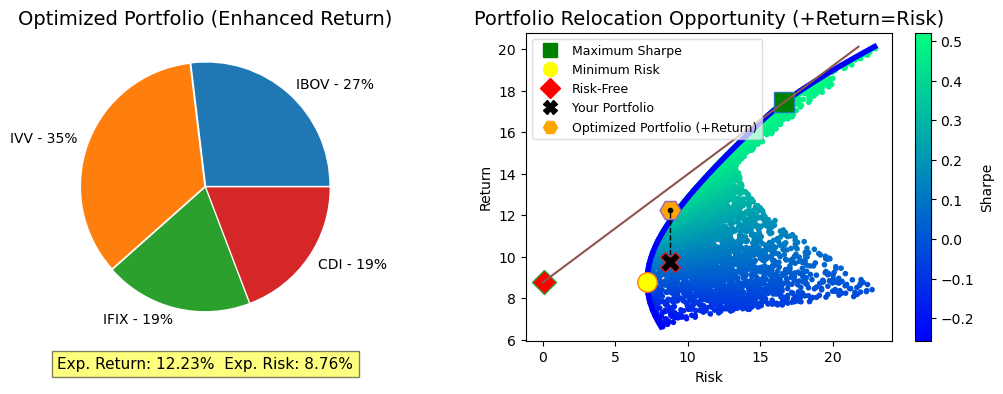

In [130]:
# Function to optimize return while maintaining the same risk
def maximize_return(weights, risk_target):
    target_risk = risk_target  # Maintain target risk
    current_risk = simulated_port_vol(weights)
    if current_risk <= target_risk:
        # If current risk is less than or equal to target, maximize return
        return -simulated_port_ret(weights)
    else:
        # If current risk is greater than target, minimize risk
        return current_risk

# Function to find the optimized allocation
def optimize_portfolio(target_function, target_value, initial_weights):
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights equal to 1
    bounds = tuple((0, 1) for asset in range(len(initial_weights)))  # Weight limits between 0 and 1
    result = sco.optimize.minimize(target_function, initial_weights, args=(target_value,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Current Allocation
current_weights = port_weights

# Optimize to maximize return while maintaining the same risk
optimized_return_weights = optimize_portfolio(maximize_return, expected_risk, current_weights)
optimized_return_ret = simulated_port_ret(optimized_return_weights)
optimized_return_vol = simulated_port_vol(optimized_return_weights)

# Support Variables
portfolio_info = (f"Exp. Return: {round(optimized_return_ret, 2)}%  Exp. Risk: {round(optimized_return_vol, 2)}%")
portfolio_list = [f'{label} - {weight*100:.0f}%' for label, weight in zip(assets_list, optimized_return_weights)]

# Creating charts - Grid
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
port_pie_chart = axs[0]
port_on_efficient_curve = axs[1]

# Chart 1 - Pie Chart
port_pie_chart.pie(optimized_return_weights, labels=portfolio_list, explode=explode)
# Adjust the space at the bottom of the pie chart
port_pie_chart.set_title('Optimized Portfolio (Enhanced Return)', fontsize=14)
port_pie_chart.text(0, -1.5, portfolio_info, ha='center', va='bottom', fontsize=11,
         bbox=dict(facecolor='yellow', alpha=0.5))

# Chart 2 - Positioning Optimized Portfolio (Enhanced Return) on Efficient Curve simulations
scatter = port_on_efficient_curve.scatter(p_vol,p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='winter')
port_on_efficient_curve.plot(tvols,trets,'b',lw=4)
port_on_efficient_curve.plot(port_vol(optimal_sharpe['x']), port_ret(optimal_sharpe['x']), 's', markerfacecolor='green', markersize=14) # Max Sharpe
port_on_efficient_curve.plot(port_vol(optimal_less_vol['x']), port_ret(optimal_less_vol['x']), 'o' , markerfacecolor='yellow', markersize=14) # Min Risk
port_on_efficient_curve.plot(v_oc, r_oc, 'D', markerfacecolor='red', markersize=12) # Risk-Free
port_on_efficient_curve.plot(return_n_risk_tpl[1], return_n_risk_tpl[0], 'X', markerfacecolor='black', markersize=15) # Your Portfolio
port_on_efficient_curve.plot(optimized_return_vol, optimized_return_ret, marker='H', markerfacecolor='orange', markersize=15) # Optimized Portfolio (Enhanced Return)

plt.plot(eixo_x, eixo_y)
# Drawing a line between Your Portfolio and Optimized Portfolio
port_on_efficient_curve.plot([expected_risk, optimized_return_vol], [expected_return, optimized_return_ret], 'o', markersize=3,
                              linestyle='--', color='black', linewidth=1)

port_on_efficient_curve.set_title('Portfolio Relocation Opportunity (+Return=Risk)', fontsize=14)
plt.xlabel('Risk')
plt.ylabel('Return')
# Creating colorbar associated with the second chart
cbar = plt.colorbar(scatter, ax=port_on_efficient_curve, label='Sharpe')

# Using mlines objects because matplotlib markers do not generate Legend
green_square = mlines.Line2D([], [], color='green', marker='s', linestyle='None',
                          markersize=10, label='Maximum Sharpe')

yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Minimum Risk')
red_diamond = mlines.Line2D([], [], color='red', marker='D', linestyle='None',
                          markersize=10, label='Risk-Free')
black_x = mlines.Line2D([], [], color='black', marker='X', linestyle='None',
                          markersize=10, label='Your Portfolio')
orange_caretup = mlines.Line2D([], [], color='orange', marker='H', linestyle='None',
                          markersize=10, label='Optimized Portfolio (+Return)')

port_on_efficient_curve.legend(handles=[green_square, yellow_circle, red_diamond, black_x, orange_caretup],
                               prop = { "size": 9 }, framealpha=0.7)
plt.show()


##### Same Return, Lower Risk

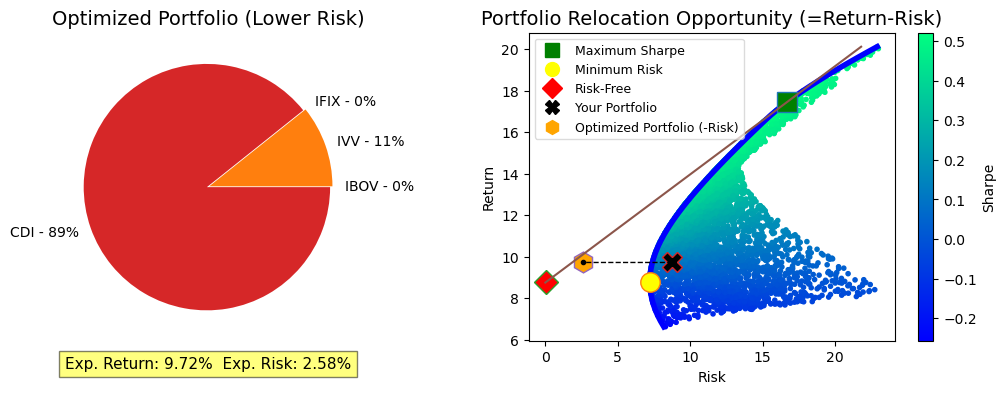

In [131]:
# Function to optimize risk while maintaining the same return
def minimize_risk(weights, return_target):
    target_return = return_target  # Maintain target return
    current_return = simulated_port_ret(weights)
    if current_return < target_return:
        # If current return is less than target, maximize return
        return -current_return
    else:
        # If current return is greater than or equal to target, minimize risk
        return simulated_port_vol(weights)

# Current Allocation
current_weights = port_weights

# Optimize to maximize return while maintaining the same risk
optimized_risk_weights = optimize_portfolio(minimize_risk, expected_return, current_weights)
optimized_risk_ret = simulated_port_ret(optimized_risk_weights)
optimized_risk_vol = simulated_port_vol(optimized_risk_weights)

# Support Variables
portfolio_info = (f"Exp. Return: {round(optimized_risk_ret, 2)}%  Exp. Risk: {round(optimized_risk_vol, 2)}%")
portfolio_list = [f'{label} - {weight*100:.0f}%' for label, weight in zip(assets_list, optimized_risk_weights)]

# Creating charts - Grid
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
port_pie_chart = axs[0]
port_on_efficient_curve = axs[1]

# Chart 1 - Pie Chart
port_pie_chart.pie(optimized_risk_weights, labels=portfolio_list, explode=explode)
# Adjust the space at the bottom of the pie chart
port_pie_chart.set_title('Optimized Portfolio (Lower Risk)', fontsize=14)
port_pie_chart.text(0, -1.5, portfolio_info, ha='center', va='bottom', fontsize=11,
         bbox=dict(facecolor='yellow', alpha=0.5))

# Chart 2 - Positioning Optimized Portfolio (Lower Risk) on Efficient Curve simulations
scatter = port_on_efficient_curve.scatter(p_vol,p_ret, c=(p_ret-risk_free_tx)/p_vol, marker='.', cmap='winter')
port_on_efficient_curve.plot(tvols,trets,'b',lw=4)
port_on_efficient_curve.plot(port_vol(optimal_sharpe['x']), port_ret(optimal_sharpe['x']), 's', markerfacecolor='green', markersize=14) # Max Sharpe
port_on_efficient_curve.plot(port_vol(optimal_less_vol['x']), port_ret(optimal_less_vol['x']), 'o' , markerfacecolor='yellow', markersize=14) # Min Risk
port_on_efficient_curve.plot(v_oc, r_oc, 'D', markerfacecolor='red', markersize=12) # Risk-Free
port_on_efficient_curve.plot(return_n_risk_tpl[1], return_n_risk_tpl[0], 'X', markerfacecolor='black', markersize=15) # Your Portfolio
port_on_efficient_curve.plot(optimized_risk_vol, optimized_risk_ret, marker='h', markerfacecolor='orange', markersize=15) # Optimized Portfolio (Lower Risk)

plt.plot(eixo_x, eixo_y)
# Drawing a line between Your Portfolio and Optimized Portfolio
port_on_efficient_curve.plot([expected_risk, optimized_risk_vol], [expected_return, optimized_risk_ret], 'o', markersize=3,
                              linestyle='--', color='black', linewidth=1)

port_on_efficient_curve.set_title('Portfolio Relocation Opportunity (=Return-Risk)', fontsize=14)
plt.xlabel('Risk')
plt.ylabel('Return')
# Creating colorbar associated with the second chart
cbar = plt.colorbar(scatter, ax=port_on_efficient_curve, label='Sharpe')

# Using mlines objects because matplotlib markers do not generate Legend
green_square = mlines.Line2D([], [], color='green', marker='s', linestyle='None',
                          markersize=10, label='Maximum Sharpe')

yellow_circle = mlines.Line2D([], [], color='yellow', marker='o', linestyle='None',
                          markersize=10, label='Minimum Risk')
red_diamond = mlines.Line2D([], [], color='red', marker='D', linestyle='None',
                          markersize=10, label='Risk-Free')
black_x = mlines.Line2D([], [], color='black', marker='X', linestyle='None',
                          markersize=10, label='Your Portfolio')
orange_caretup = mlines.Line2D([], [], color='orange', marker='h', linestyle='None',
                          markersize=10, label='Optimized Portfolio (-Risk)')

port_on_efficient_curve.legend(handles=[green_square, yellow_circle, red_diamond, black_x, orange_caretup],
                               prop = { "size": 9 }, framealpha=0.7)
plt.show()